# Large Artificial Neural Network Heuristic: performance analysis

In this notebook, we analyze the performance of the second, large, ANN heuristic that we trained. The ANN is a feed-forward fully-connected neural network composed of an input layer with 256 neurons, ten hidden layers with 3x4096, 4x2048 and 3x1024 hidden neurons, and an output layer composed of a single neuron. An input is a board state (16 indexes of pebbles, with each index one-hot encoded, resulting in a 256-dimensional input vector). The target value for each input is the length of its optimal solution.

The neural network was trained on a dataset of roughly 100 million optimal solutions, with distribution similar to a distribution created by randomly permutating the board pebbles (and discarding unsolvable results), but much more skewed to the right in respect of optimal solution length (so that the training data would include short optimal solutions as well).

The tests were run on boards created by random permutations. **The same dataset (with about 140 boards) was used for testing three different heuristics**, which are described in their corresponding sections. The algorithm used for searching is A*.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Data preprocessing

In [4]:
results = pd.read_csv("/home/batman/code/fifteen-puzzle/data/experiments/ann-heuristic-benchmark-large.csv")
results.shape

(408, 9)

In [6]:
results.head(10)

,PROCESS_ID,BOARD_ID,ALGORITHM_NAME,HEURISTIC_NAME,BOARDS_GENERATOR_NAME,RUN_TIME,SOLUTION_COST,EXPANDED_NODES,INITIAL_HEURISTIC_PREDICTION
0,2019-03-30 18:52:10.360472 PID7861,1,A*,PDB[Pat:5],RND,91.575918,52,800446,42.000000
1,2019-03-30 18:52:10.360472 PID7861,1,A*,ANN[Const:0;Label:small],RND,69.671113,52,27580,49.796761
2,2019-03-30 18:52:10.360528 PID7860,1,A*,PDB[Pat:5],RND,549.545209,59,4705062,45.000000
3,2019-03-30 18:52:10.360528 PID7860,1,A*,ANN[Const:0;Label:small],RND,177.142951,59,47030,56.663700
4,2019-03-30 18:52:10.360472 PID7861,1,A*,ANN[Const:0;Label:large],RND,610.049880,52,17965,49.810261
5,2019-03-30 18:52:10.360472 PID7861,2,A*,PDB[Pat:5],RND,173.659145,54,1488122,40.000000
6,2019-03-30 18:52:10.360472 PID7861,2,A*,ANN[Const:0;Label:small],RND,51.223245,54,13606,53.252373
7,2019-03-30 18:52:10.360472 PID7861,2,A*,ANN[Const:0;Label:large],RND,405.844847,54,8843,53.170418
8,2019-03-30 18:52:10.360472 PID7861,3,A*,PDB[Pat:5],RND,5.655071,49,53310,39.000000
9,2019-03-30 18:52:10.360472 PID7861,3,A*,ANN[Const:0;Label:small],RND,14.756467,49,3331,48.136337


In [7]:
results["HEURISTIC_NAME"].unique()

array(['PDB[Pat:5]', 'ANN[Const:0;Label:small]',
       'ANN[Const:0;Label:large]'], dtype=object)

In [29]:
pdb_results = results[results["HEURISTIC_NAME"] == "PDB[Pat:5]"]
ann_small_results = results[results["HEURISTIC_NAME"] == "ANN[Const:0;Label:small]"]
ann_large_results = results[results["HEURISTIC_NAME"] == "ANN[Const:0;Label:large]"]

In [31]:
ann_large_results.describe()

,BOARD_ID,RUN_TIME,SOLUTION_COST,EXPANDED_NODES,INITIAL_HEURISTIC_PREDICTION
count,136.000000,136.000000,136.000000,136.000000,136.000000
mean,34.507353,459.056174,52.823529,11242.735294,52.617452
std,19.713126,750.943204,5.371919,18218.387832,5.099897
min,1.000000,6.350847,32.000000,182.000000,32.193642
25%,17.750000,78.595565,50.000000,1720.750000,49.914837
50%,34.500000,230.548069,53.000000,5464.000000,52.769232
75%,51.250000,462.975566,56.000000,11670.500000,55.936382
max,69.000000,4431.709588,65.000000,102413.000000,64.467789


In [9]:
def optimal_cost(row):
    process_id = row["PROCESS_ID"]
    board_id = row["BOARD_ID"]
    
    pdb_row_df = pdb_results[(pdb_results.PROCESS_ID == process_id) & (pdb_results.BOARD_ID == board_id)]
    return pdb_row_df.iloc[0]["SOLUTION_COST"]

In [10]:
results_complete = results.copy()

results_complete["OPTIMAL_SOLUTION_COST"] = results_complete.apply(lambda row: optimal_cost(row), axis=1)
results_complete["SOLUTION_COST_ERROR"] = results_complete["SOLUTION_COST"] - results_complete["OPTIMAL_SOLUTION_COST"]
results_complete["INITIAL_HEURISTIC_PREDICTION_ERROR"] = results_complete["INITIAL_HEURISTIC_PREDICTION"] - results_complete["OPTIMAL_SOLUTION_COST"]

In [12]:
results_complete.head(20)

,PROCESS_ID,BOARD_ID,ALGORITHM_NAME,HEURISTIC_NAME,BOARDS_GENERATOR_NAME,RUN_TIME,SOLUTION_COST,EXPANDED_NODES,INITIAL_HEURISTIC_PREDICTION,OPTIMAL_SOLUTION_COST,SOLUTION_COST_ERROR,INITIAL_HEURISTIC_PREDICTION_ERROR
0,2019-03-30 18:52:10.360472 PID7861,1,A*,PDB[Pat:5],RND,91.575918,52,800446,42.000000,52,0,-10.000000
1,2019-03-30 18:52:10.360472 PID7861,1,A*,ANN[Const:0;Label:small],RND,69.671113,52,27580,49.796761,52,0,-2.203239
2,2019-03-30 18:52:10.360528 PID7860,1,A*,PDB[Pat:5],RND,549.545209,59,4705062,45.000000,59,0,-14.000000
3,2019-03-30 18:52:10.360528 PID7860,1,A*,ANN[Const:0;Label:small],RND,177.142951,59,47030,56.663700,59,0,-2.336300
4,2019-03-30 18:52:10.360472 PID7861,1,A*,ANN[Const:0;Label:large],RND,610.049880,52,17965,49.810261,52,0,-2.189739
5,2019-03-30 18:52:10.360472 PID7861,2,A*,PDB[Pat:5],RND,173.659145,54,1488122,40.000000,54,0,-14.000000
6,2019-03-30 18:52:10.360472 PID7861,2,A*,ANN[Const:0;Label:small],RND,51.223245,54,13606,53.252373,54,0,-0.747627
7,2019-03-30 18:52:10.360472 PID7861,2,A*,ANN[Const:0;Label:large],RND,405.844847,54,8843,53.170418,54,0,-0.829582
8,2019-03-30 18:52:10.360472 PID7861,3,A*,PDB[Pat:5],RND,5.655071,49,53310,39.000000,49,0,-10.000000
9,2019-03-30 18:52:10.360472 PID7861,3,A*,ANN[Const:0;Label:small],RND,14.756467,49,3331,48.136337,49,0,-0.863663


In [32]:
pdb_results_complete = results_complete[results_complete["HEURISTIC_NAME"] == "PDB[Pat:5]"]
ann_small_results_complete = results_complete[results_complete["HEURISTIC_NAME"] == "ANN[Const:0;Label:small]"]
ann_large_results_complete = results_complete[results_complete["HEURISTIC_NAME"] == "ANN[Const:0;Label:large]"]

## Analysis of results

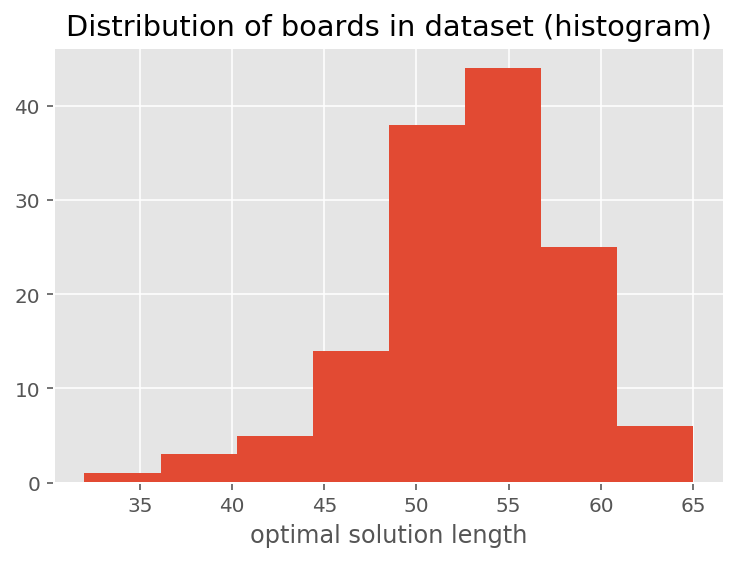

In [44]:
plt.hist(pdb_results["SOLUTION_COST"], bins=8);
plt.title("Distribution of boards in dataset (histogram)")
plt.xlabel("optimal solution length");

### Pattern Database Heuristic (5, 5, 5) - optimal solutions

A pattern database heuristic with 3 patterns of size 5. Usage with A* guarantees optimal results.

In [33]:
pdb_results_complete.describe()

,BOARD_ID,RUN_TIME,SOLUTION_COST,EXPANDED_NODES,INITIAL_HEURISTIC_PREDICTION,OPTIMAL_SOLUTION_COST,SOLUTION_COST_ERROR,INITIAL_HEURISTIC_PREDICTION_ERROR
count,136.000000,136.000000,136.000000,1.360000e+02,136.000000,136.000000,136.0,136.000000
mean,34.507353,140.974667,52.617647,1.245366e+06,40.735294,52.617647,0.0,-11.882353
std,19.713126,272.158976,5.269140,2.394182e+06,4.662276,5.269140,0.0,2.979085
min,1.000000,0.184901,32.000000,1.792000e+03,22.000000,32.000000,0.0,-18.000000
25%,17.750000,12.391576,50.000000,1.174302e+05,38.000000,50.000000,0.0,-14.000000
50%,34.500000,52.724454,53.000000,4.578120e+05,41.000000,53.000000,0.0,-12.000000
75%,51.250000,156.303259,56.000000,1.389073e+06,44.000000,56.000000,0.0,-10.000000
max,69.000000,2084.966141,65.000000,1.816608e+07,54.000000,65.000000,0.0,-4.000000


### Small Artificial Neural Network Heuristic

In [34]:
ann_small_results_complete.describe()

,BOARD_ID,RUN_TIME,SOLUTION_COST,EXPANDED_NODES,INITIAL_HEURISTIC_PREDICTION,OPTIMAL_SOLUTION_COST,SOLUTION_COST_ERROR,INITIAL_HEURISTIC_PREDICTION_ERROR
count,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000
mean,34.507353,50.485369,53.073529,12368.897059,52.511502,52.617647,0.455882,-0.106145
std,19.713126,67.001822,5.360531,16869.347091,5.268958,5.269140,0.842111,1.455977
min,1.000000,0.907183,32.000000,243.000000,31.888334,32.000000,0.000000,-2.947426
25%,17.750000,10.141929,50.000000,2471.750000,49.693511,50.000000,0.000000,-1.208284
50%,34.500000,22.267449,53.000000,5303.000000,52.679352,53.000000,0.000000,-0.244778
75%,51.250000,64.573061,56.000000,15389.500000,55.567104,56.000000,0.000000,0.745923
max,69.000000,381.040345,65.000000,95554.000000,66.658325,65.000000,2.000000,3.934872


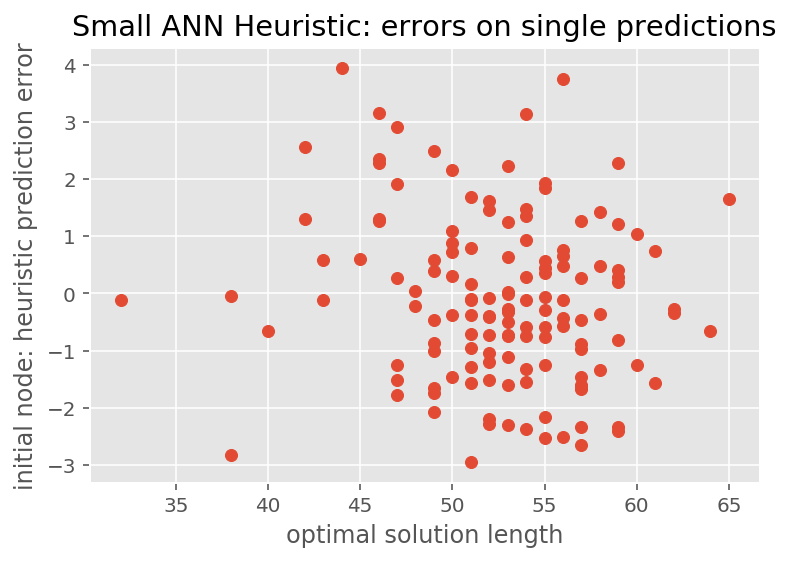

In [54]:
plt.scatter(ann_small_results_complete["OPTIMAL_SOLUTION_COST"], ann_small_results_complete["INITIAL_HEURISTIC_PREDICTION_ERROR"])
# plt.scatter(ann_large_results_complete["OPTIMAL_SOLUTION_COST"], ann_large_results_complete["INITIAL_HEURISTIC_PREDICTION_ERROR"])
plt.title("Small ANN Heuristic: errors on single predictions")
plt.xlabel("optimal solution length")
plt.ylabel("initial node: heuristic prediction error");

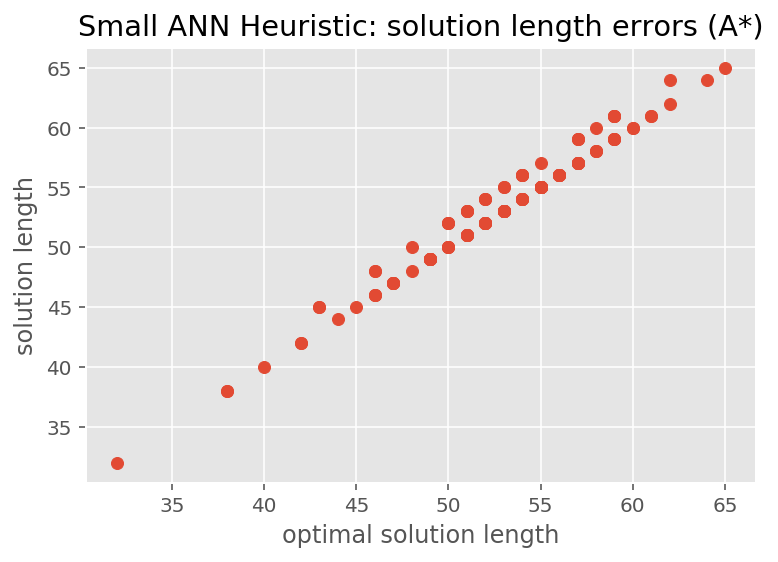

In [36]:
plt.scatter(ann_small_results_complete["OPTIMAL_SOLUTION_COST"], ann_small_results_complete["SOLUTION_COST"])
plt.title("Small ANN Heuristic: solution length errors (A*)")
plt.xlabel("optimal solution length")
plt.ylabel("solution length");

### Large Artificial Neural Network Heuristic

Improvements over the Small Artificial Neural Network Heuristic:
- Mean solution cost error: 0.21 (vs 0.46)
- Slightly lower expanded nodes count

Limitations:
- Average runtime: 459 s (vs 50 s)

In [37]:
pdb_results_complete.describe()

,BOARD_ID,RUN_TIME,SOLUTION_COST,EXPANDED_NODES,INITIAL_HEURISTIC_PREDICTION,OPTIMAL_SOLUTION_COST,SOLUTION_COST_ERROR,INITIAL_HEURISTIC_PREDICTION_ERROR
count,136.000000,136.000000,136.000000,1.360000e+02,136.000000,136.000000,136.0,136.000000
mean,34.507353,140.974667,52.617647,1.245366e+06,40.735294,52.617647,0.0,-11.882353
std,19.713126,272.158976,5.269140,2.394182e+06,4.662276,5.269140,0.0,2.979085
min,1.000000,0.184901,32.000000,1.792000e+03,22.000000,32.000000,0.0,-18.000000
25%,17.750000,12.391576,50.000000,1.174302e+05,38.000000,50.000000,0.0,-14.000000
50%,34.500000,52.724454,53.000000,4.578120e+05,41.000000,53.000000,0.0,-12.000000
75%,51.250000,156.303259,56.000000,1.389073e+06,44.000000,56.000000,0.0,-10.000000
max,69.000000,2084.966141,65.000000,1.816608e+07,54.000000,65.000000,0.0,-4.000000


In [39]:
ann_small_results_complete.describe()

,BOARD_ID,RUN_TIME,SOLUTION_COST,EXPANDED_NODES,INITIAL_HEURISTIC_PREDICTION,OPTIMAL_SOLUTION_COST,SOLUTION_COST_ERROR,INITIAL_HEURISTIC_PREDICTION_ERROR
count,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000
mean,34.507353,50.485369,53.073529,12368.897059,52.511502,52.617647,0.455882,-0.106145
std,19.713126,67.001822,5.360531,16869.347091,5.268958,5.269140,0.842111,1.455977
min,1.000000,0.907183,32.000000,243.000000,31.888334,32.000000,0.000000,-2.947426
25%,17.750000,10.141929,50.000000,2471.750000,49.693511,50.000000,0.000000,-1.208284
50%,34.500000,22.267449,53.000000,5303.000000,52.679352,53.000000,0.000000,-0.244778
75%,51.250000,64.573061,56.000000,15389.500000,55.567104,56.000000,0.000000,0.745923
max,69.000000,381.040345,65.000000,95554.000000,66.658325,65.000000,2.000000,3.934872


In [38]:
ann_large_results_complete.describe()

,BOARD_ID,RUN_TIME,SOLUTION_COST,EXPANDED_NODES,INITIAL_HEURISTIC_PREDICTION,OPTIMAL_SOLUTION_COST,SOLUTION_COST_ERROR,INITIAL_HEURISTIC_PREDICTION_ERROR
count,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000
mean,34.507353,459.056174,52.823529,11242.735294,52.617452,52.617647,0.205882,-0.000195
std,19.713126,750.943204,5.371919,18218.387832,5.099897,5.269140,0.656790,1.265216
min,1.000000,6.350847,32.000000,182.000000,32.193642,32.000000,0.000000,-2.755932
25%,17.750000,78.595565,50.000000,1720.750000,49.914837,50.000000,0.000000,-0.792529
50%,34.500000,230.548069,53.000000,5464.000000,52.769232,53.000000,0.000000,-0.167484
75%,51.250000,462.975566,56.000000,11670.500000,55.936382,56.000000,0.000000,0.773909
max,69.000000,4431.709588,65.000000,102413.000000,64.467789,65.000000,4.000000,3.070545


## (Unused code)

In [22]:
# results_wide = (
#     results[results.ALGORITHM_NAME == 'A*']
#     .drop('ALGORITHM_NAME', 1)
#     .pivot(index='BOARD_ID', columns='HEURISTIC_NAME')
# )

In [46]:
# groups = dict(list(results.groupby(['ALGORITHM_NAME', 'HEURISTIC_NAME'])))
# groups.keys()

dict_keys([('AStarSearch', 'ANNHeuristic[Additive constant: -2]'), ('AStarSearch', 'ANNHeuristic[Additive constant: 0]'), ('AStarSearch', 'ANNHeuristic[Additive constant: 2]'), ('AStarSearch', 'PatternDatabaseHeuristic'), ('IDAStarSearch', 'ANNHeuristic[Additive constant: -2]'), ('IDAStarSearch', 'ANNHeuristic[Additive constant: 0]'), ('IDAStarSearch', 'ANNHeuristic[Additive constant: 2]'), ('IDAStarSearch', 'PatternDatabaseHeuristic')])

In [27]:
# results.groupby(['ALGORITHM_NAME', 'HEURISTIC_NAME']).mean()

BOARD_ID  RUN_TIME  \
ALGORITHM_NAME HEURISTIC_NAME                                            
AStarSearch    ANNHeuristic[Additive constant: -2]      15.5  0.411816   
               ANNHeuristic[Additive constant: 0]       15.5  0.406954   
               ANNHeuristic[Additive constant: 2]       15.5  0.401545   
               PatternDatabaseHeuristic                 15.5  0.018106   
IDAStarSearch  ANNHeuristic[Additive constant: -2]      15.5  1.231351   
               ANNHeuristic[Additive constant: 0]       15.5  1.264256   
               ANNHeuristic[Additive constant: 2]       15.0  1.251357   
               PatternDatabaseHeuristic                 15.5  0.015557   

                                                    SOLUTION_COST  \
ALGORITHM_NAME HEURISTIC_NAME                                       
AStarSearch    ANNHeuristic[Additive constant: -2]      19.000000   
               ANNHeuristic[Additive constant: 0]       19.000000   
               ANNHeuristic[Additive constant: 2]       19.000000   
               PatternDatabaseHeuristic                 19.000000   
IDAStarSearch  ANNHeuristic[Additive constant: -2]      23.000000   
               ANNHeuristic[Additive constant: 0]       25.000000   
               ANNHeuristic[Additive constant: 2]       26.965517   
               PatternDatabaseHeuristic                 19.000000   

                                                    EXPANDED_NODES  
ALGORITHM_NAME HEURISTIC_NAME                                       
AStarSearch    ANNHeuristic[Additive constant: -2]      120.933333  
               ANNHeuristic[Additive constant: 0]       120.933333  
               ANNHeuristic[Additive constant: 2]       120.933333  
               PatternDatabaseHeuristic                  65.300000  
IDAStarSearch  ANNHeuristic[Additive constant: -2]      385.600000  
               ANNHeuristic[Additive constant: 0]       385.600000  
               ANNHeuristic[Additive constant: 2]       379.965517  
               PatternDatabaseHeuristic                  73.566667